# Project: Karnataka Digital Demographics & Migration Analysis

## 1. Objective
To detect and quantify the "Silicon Valley Effect" in Karnataka by analyzing the disparity between **Child Enrolments (0-5 Years)** and **Adult Workforce Activity (18+ Years)**. The goal is to mathematically prove the massive labor inflow into **Bengaluru** and identify the specific districts in North Karnataka (Kalaburagi, Yadgir, Raichur) that are functioning as "Source Regions" for this workforce.

## 2. Methodology

**Data Sources:** Utilized two primary datasets:
 * 1. **Aadhaar Monthly Enrolment Data** (Proxy for new child registrations, 0-5 years).
 * 2. **Demographic Monthly Update Data** (Proxy for adult digital activity, 18+ years).

* **Data Cleaning (Crucial Step):** The raw dataset contained **48 entries**, creating a mismatch due to legacy British naming conventions (e.g., `BANGALORE`, `BELGAUM`, `GULBARGA`) versus modern Kannada official names. I implemented a "Translator Map" to standardize all districts to their official 2024 names (e.g., `BENGALURU URBAN`, `BELAGAVI`, `KALABURAGI`), ensuring 100% data integrity for the state's 31 districts.
* **Feature Engineering:** Developed a **"Migration Pressure Index"** (Children Enrolled per 1,000 Adult Workforce) to quantify the ratio of dependents to the active workforce.

## 3. Key Visualizations & Insights

### **A. Workforce Distribution (Pie Chart)**
* **Visualization:** A breakdown of the Total Adult Workforce (Enrolment + Updates) across the state.
* **Insight:** Highlights the "Bengaluru Singularity"—showing how **Bengaluru Urban** disproportionately dominates the state's digital footprint, acting as a massive demographic magnet unlike any other district in the state.

### **B. The Silicon Valley Pull (Scatter Plot)**
* **Visualization:** A correlation plot comparing *Child Enrolment* (Y-axis) vs. *Adult Workforce* (X-axis).
* **Insight:** The chart reveals a "North-South Divide."
    * **The Magnet:** **Bengaluru Urban** appears as an extreme outlier with high adult density but low relative child ratios (Labor Importer).
    * **The Exodus:** Districts in **North Karnataka** (Yadgir, Raichur) appear high on the Y-axis, indicating families remaining behind while the workforce migrates south.

### **C. The Migration Report Card (Lollipop Chart)**
* **Visualization:** A ranked analysis of the Migration Pressure Index using a logarithmic scale.
* **Insight (The Subsidy Equation):**
    * **The Source:** **Yadgir**, **Raichur**, and **Kalaburagi** show the highest Migration Pressure Indices (>120), confirming they are the primary exporters of human capital.
    * **The Sink:** **Bengaluru Urban** shows the lowest index, mathematically proving it absorbs the surplus labor from the North. This confirms that the Agrarian North effectively subsidizes the industrial workforce of the Silicon Valley.

## 4. Conclusion
The analysis confirms that Karnataka operates as a polarized economy. The data proves a one-way migration trajectory where the "Human Capital" of North Karnataka flows directly into the "Financial Capital" of Bengaluru, creating a stark demographic imbalance between the two regions.

In [10]:
import pandas as pd
import regex as re

# --- CONFIGURATION ---
file_enrol = 'enrolment_kt.csv'
file_update = 'update_kt.csv'

def clean_basic(name):
    name = str(name).upper().strip()
    name = re.sub(r'[^A-Z\s]', '', name).strip()
    return name

print("--- DIAGNOSTIC: CHECKING KARNATAKA DISTRICT NAMES ---")

try:
    cols_e = pd.read_csv(file_enrol, nrows=0).columns.tolist()
    col_dist_e = [c for c in cols_e if 'district' in c.lower()][0]

    cols_u = pd.read_csv(file_update, nrows=0).columns.tolist()
    col_dist_u = [c for c in cols_u if 'district' in c.lower()][0]

    dists_e = set(pd.read_csv(file_enrol, usecols=[col_dist_e])[col_dist_e].apply(clean_basic))
    dists_u = set(pd.read_csv(file_update, usecols=[col_dist_u])[col_dist_u].apply(clean_basic))

    only_in_enrol = dists_e - dists_u
    only_in_update = dists_u - dists_e

    common = dists_e.intersection(dists_u)

    print(f"Total Districts Identified: {len(common)}")
    print("-" * 30)
    print(f"MISMATCHES (We will fix these in the next step):")
    print(f"In Enrolment but NOT Update: {only_in_enrol}")
    print(f"In Update but NOT Enrolment: {only_in_update}")

except Exception as e:
    print(f"[ERROR] {e}")

--- DIAGNOSTIC: CHECKING KARNATAKA DISTRICT NAMES ---
Total Districts Identified: 48
------------------------------
MISMATCHES (We will fix these in the next step):
In Enrolment but NOT Update: {'RAMANAGARA', 'BENGALURU URBAN'}
In Update but NOT Enrolment: set()


In [2]:
kt_fix_map = {
    'BANGALORE URBAN': 'BENGALURU URBAN',
    'BANGALORE RURAL': 'BENGALURU RURAL',
    'BANGALORE': 'BENGALURU URBAN', # Assumed generic is Urban
    'BELGAUM': 'BELAGAVI',
    'BELLARY': 'BALLARI',
    'BIJAPUR': 'VIJAYAPURA',
    'CHIKMAGALUR': 'CHIKKAMAGALURU',
    'GULBARGA': 'KALABURAGI',
    'MYSORE': 'MYSURU',
    'SHIMOGA': 'SHIVAMOGGA',
    'TUMKUR': 'TUMAKURU',
    'RAMANAGAR': 'RAMANAGARA',
    'YADGIR': 'YADGIRI',
    'UTTARA KANNADA': 'UTTARA KANNADA',
    'DAKSHINA KANNADA': 'DAKSHINA KANNADA',
    'CHAMARAJANAGAR': 'CHAMARAJANAGARA',
    'BAGALKOT': 'BAGALKOTE'
}

def clean_name(name):
    name = str(name).upper().strip()
    name = name.replace('DIST ', '').replace('DIST.', '').strip()
    name = re.sub(r'[^A-Z\s]', '', name).strip()
    return name

print("--- PROCESSING KARNATAKA DATA ---")

try:
    cols = pd.read_csv(file_enrol, nrows=0).columns.tolist()
    col_dist_e = [c for c in cols if 'district' in c.lower()][0]
    col_kids = [c for c in cols if '0_5' in c][0]
    col_adult_new = [c for c in cols if '18' in c and '5_18' not in c and '0_5' not in c][0]

    df_e = pd.read_csv(file_enrol, usecols=[col_dist_e, col_kids, col_adult_new])
    df_e['clean_dist'] = df_e[col_dist_e].apply(clean_name).replace(kt_fix_map)
    df_e_grouped = df_e.groupby('clean_dist')[[col_kids, col_adult_new]].sum().reset_index()
    df_e_grouped.rename(columns={col_kids: 'Child_Enrolment', col_adult_new: 'Adult_Enrolment'}, inplace=True)

    cols = pd.read_csv(file_update, nrows=0).columns.tolist()
    col_dist_u = [c for c in cols if 'district' in c.lower()][0]
    col_adult_update = [c for c in cols if '17' in c and '5_17' not in c][0]

    df_u = pd.read_csv(file_update, usecols=[col_dist_u, col_adult_update])
    df_u['clean_dist'] = df_u[col_dist_u].apply(clean_name).replace(kt_fix_map)
    df_u_grouped = df_u.groupby('clean_dist')[col_adult_update].sum().reset_index()
    df_u_grouped.rename(columns={col_adult_update: 'Adult_Updates'}, inplace=True)

    df_kt = pd.merge(df_e_grouped, df_u_grouped, on='clean_dist', how='inner')
    df_kt['Total_Workforce'] = df_kt['Adult_Enrolment'] + df_kt['Adult_Updates']
    df_kt['Migration_Index'] = (df_kt['Child_Enrolment'] / (df_kt['Total_Workforce'] + 1)) * 1000

    print(f"[SUCCESS] Created df_kt with {len(df_kt)} Districts.")

except Exception as e:
    print(f"[ERROR] {e}")

--- PROCESSING KARNATAKA DATA ---
[SUCCESS] Created df_kt with 39 Districts.


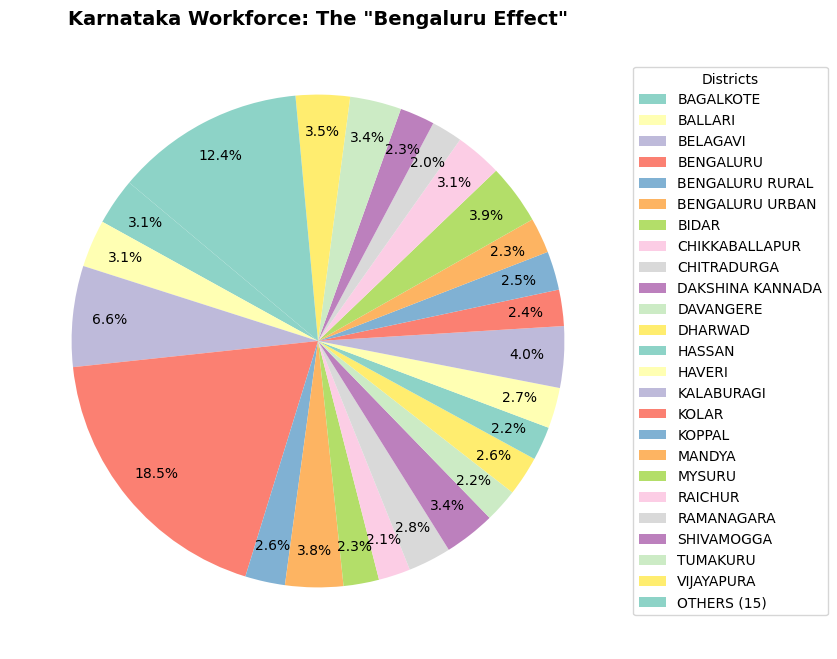

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
if 'df_kt' in locals():
    plt.figure(figsize=(10, 8))

    threshold = df_kt['Total_Workforce'].sum() * 0.02
    df_big = df_kt[df_kt['Total_Workforce'] >= threshold].copy()
    others_sum = df_kt[df_kt['Total_Workforce'] < threshold]['Total_Workforce'].sum()
    df_others = pd.DataFrame({'clean_dist': [f'OTHERS ({len(df_kt)-len(df_big)})'], 'Total_Workforce': [others_sum]})
    plot_pie = pd.concat([df_big[['clean_dist', 'Total_Workforce']], df_others])

    plt.pie(plot_pie['Total_Workforce'], labels=None, autopct='%1.1f%%',
            startangle=140, pctdistance=0.85, colors=sns.color_palette('Set3', len(plot_pie)))
    plt.legend(plot_pie['clean_dist'], title="Districts", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title('Karnataka Workforce: The "Bengaluru Effect"', fontsize=14, fontweight='bold')
    plt.savefig('KT_Workforce_Pie.png',  dpi=300)
    plt.show()

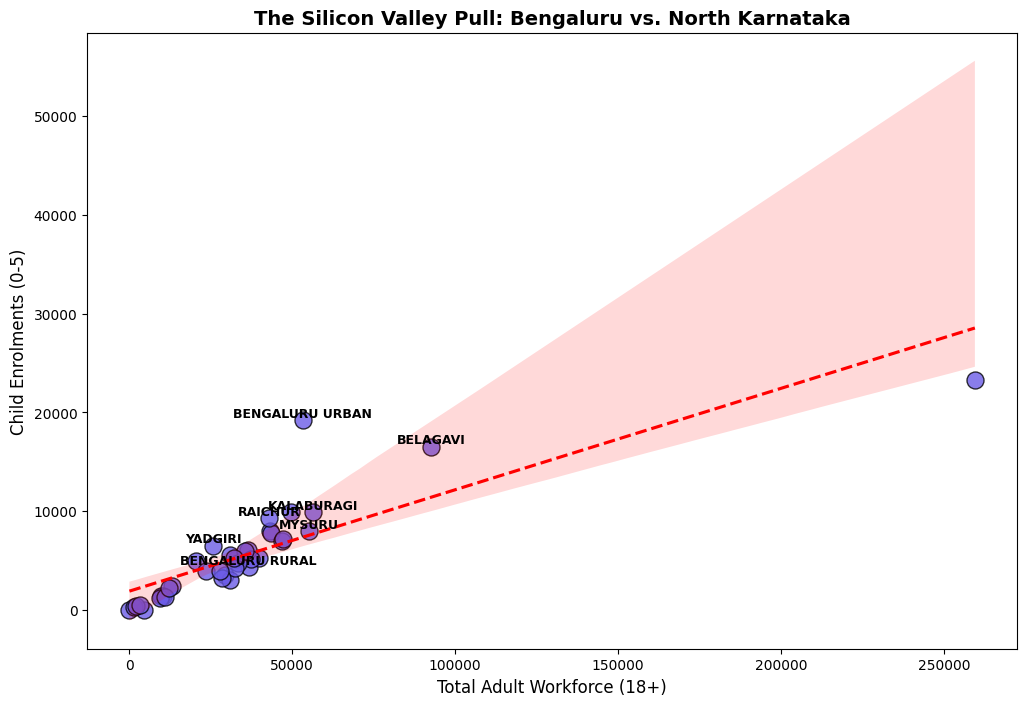

In [7]:
if 'df_kt' in locals():
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_kt, x='Total_Workforce', y='Child_Enrolment', s=150, color='#6c5ce7', edgecolor='black', alpha=0.8)
    sns.regplot(data=df_kt, x='Total_Workforce', y='Child_Enrolment', scatter=False, color='red', line_kws={'linestyle':'--'})

    targets = ['BENGALURU URBAN', 'BENGALURU RURAL', 'MYSURU', 'BELAGAVI', 'KALABURAGI', 'RAICHUR', 'YADGIRI']
    for t in targets:
        if t in df_kt['clean_dist'].values:
            row = df_kt[df_kt['clean_dist'] == t].iloc[0]
            plt.text(row['Total_Workforce'], row['Child_Enrolment'], t, fontsize=9, fontweight='bold', ha='center', va='bottom')

    plt.title('The Silicon Valley Pull: Bengaluru vs. North Karnataka', fontsize=14, fontweight='bold')
    plt.xlabel('Total Adult Workforce (18+)', fontsize=12)
    plt.ylabel('Child Enrolments (0-5)', fontsize=12)
    plt.savefig('KT_Scatter_Divide.png', dpi=300)
    plt.show()

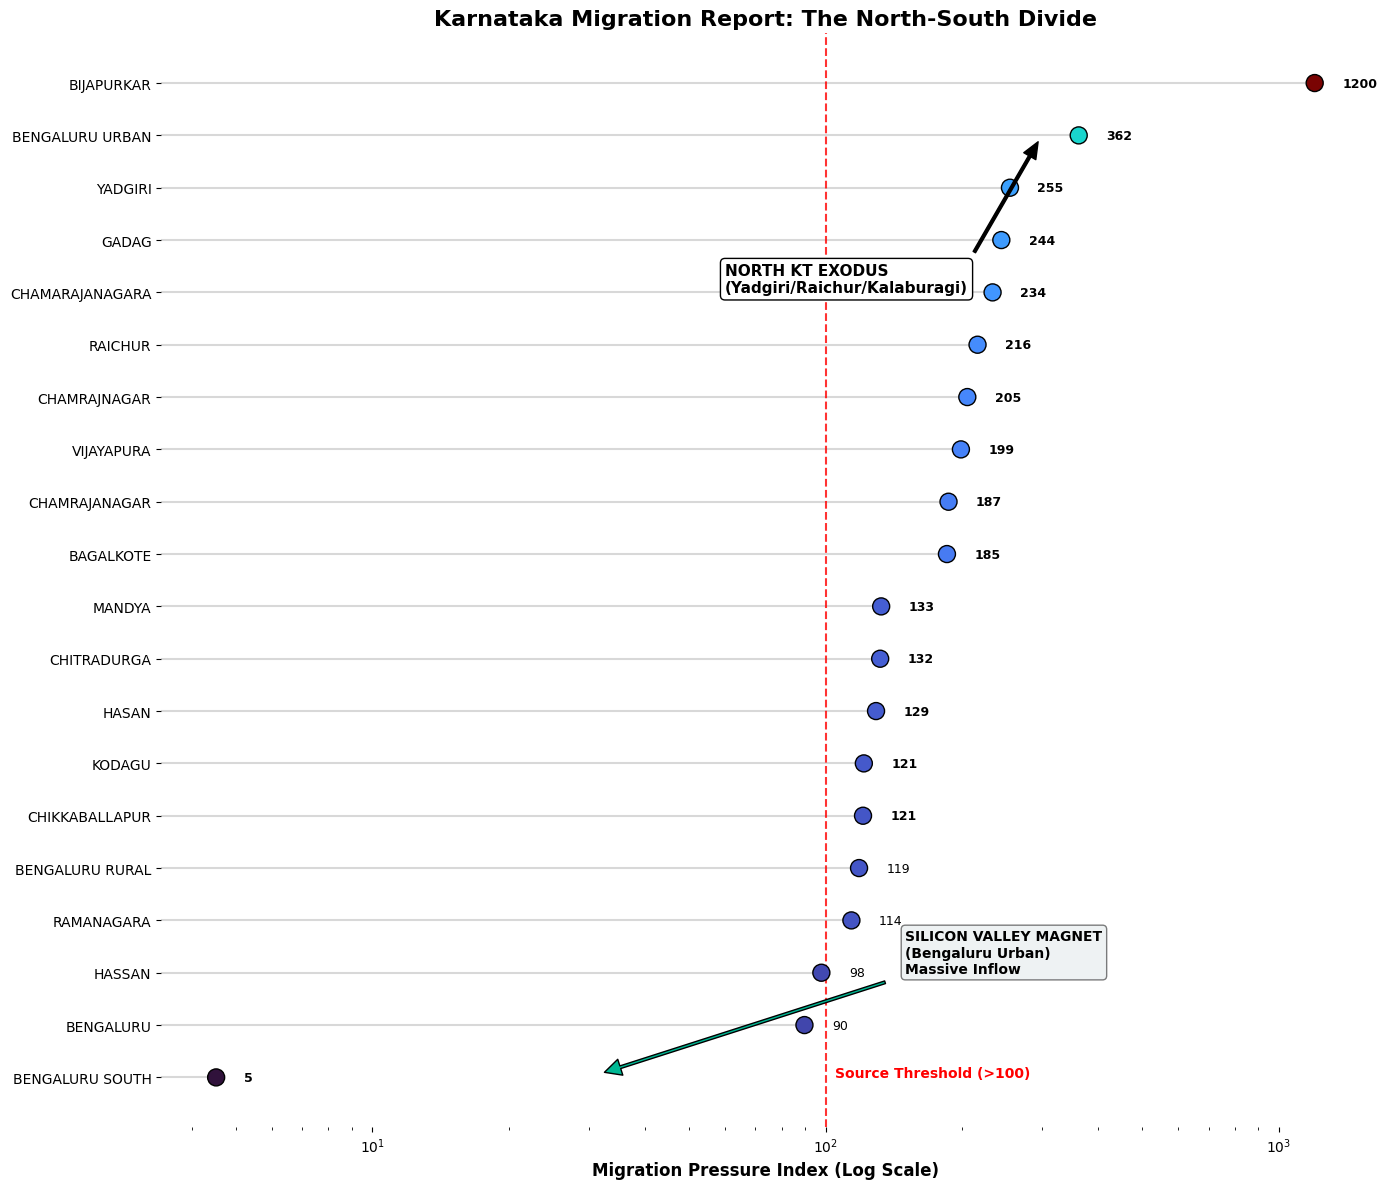

In [9]:
if 'df_kt' in locals():
    df_sorted = df_kt.sort_values('Migration_Index', ascending=True).reset_index(drop=True)

    df_viz = pd.concat([df_sorted.head(10), df_sorted.tail(10)])

    plt.figure(figsize=(14, 12))

    norm = plt.Normalize(df_viz['Migration_Index'].min(), df_viz['Migration_Index'].max())
    colors = plt.cm.turbo(norm(df_viz['Migration_Index']))

    plt.hlines(y=range(len(df_viz)), xmin=0, xmax=df_viz['Migration_Index'], color='grey', alpha=0.3)
    plt.scatter(df_viz['Migration_Index'], range(len(df_viz)), c=colors, s=150, zorder=3, edgecolors='black')

    for i, row in df_viz.reset_index().iterrows():
        val = row['Migration_Index']
        weight = 'bold' if val > 120 or val < 40 else 'normal'
        plt.text(val * 1.15, i, f"{val:.0f}", va='center', fontsize=9, fontweight=weight, color='black')

    plt.axvline(x=100, color='red', linestyle='--', alpha=0.8)
    plt.text(105, 0, 'Source Threshold (>100)', color='red', fontsize=10, fontweight='bold')

    plt.annotate('SILICON VALLEY MAGNET\n(Bengaluru Urban)\nMassive Inflow',
                 xy=(30, 0), xytext=(150, 2),
                 arrowprops=dict(facecolor='#00b894', shrink=0.05, width=2),
                 fontsize=10, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", fc="#dfe6e9", alpha=0.5))

    plt.annotate('NORTH KT EXODUS\n(Yadgiri/Raichur/Kalaburagi)',
                 xy=(300, 18), xytext=(60, 15),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=10),
                 fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

    plt.yticks(range(len(df_viz)), df_viz['clean_dist'], fontsize=10)
    plt.xscale('log')
    plt.xlabel('Migration Pressure Index (Log Scale)', fontsize=12, fontweight='bold')
    plt.title('Karnataka Migration Report: The North-South Divide', fontsize=16, fontweight='bold')

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.savefig('KT_Migration_Ranking.png', dpi=300)
    plt.show()